In [1]:
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
import optax
import time
import pickle

## Load Full Dataset

In [2]:
from datasets import load_dataset

dataset = load_dataset("afmck/text8")
full_text = dataset["train"][0]["text"]

# 80/20 split
split_idx = int(len(full_text) * 0.8)
train_text = full_text[:split_idx]
val_text = full_text[split_idx:]

print(f"Training length: {len(train_text)}, Test length: {len(val_text)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/485 [00:00<?, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/48.9M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/2.74M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1 [00:00<?, ? examples/s]

Training length: 72000000, Test length: 18000000


## Tokenizer

In [3]:
char_set = list("abcdefghijklmnopqrstuvwxyz ")
char_to_int = {ch:i for i,ch in enumerate(char_set)}
int_to_char = {i:ch for ch,i in char_to_int.items()}

def encode(s):
    return np.array([char_to_int[c] for c in s], dtype=np.uint8)

def decode(ids):
    return ''.join(int_to_char[i] for i in ids)

# Encode
train_text_int = encode(train_text)
test_text_int = encode(val_text)

## Model Definition

In [4]:
class MLP(nn.Module):
    d_model: int
    mlp_ratio: int
    mlp_dropout: float
    kernel_init: any
    compute_dtype: any

    @nn.compact
    def __call__(self, x, *, deterministic=True):
        hidden = int(self.d_model * self.mlp_ratio)
        x = nn.Dense(hidden, kernel_init=self.kernel_init, dtype=self.compute_dtype)(x)
        x = nn.gelu(x)
        x = nn.Dropout(self.mlp_dropout)(x, deterministic=deterministic)
        x = nn.Dense(self.d_model, kernel_init=self.kernel_init, dtype=self.compute_dtype)(x)
        return x

class DecoderBlock(nn.Module):
    d_model: int
    n_heads: int
    mlp_ratio: int
    attn_dropout: float
    mlp_dropout: float
    kernel_init: any
    compute_dtype: any

    @nn.compact
    def __call__(self, x, *, mask=None, deterministic=True):
        h = nn.LayerNorm(dtype=jnp.float32)(x)
        h = nn.SelfAttention(
            num_heads=self.n_heads,
            use_bias=False,
            kernel_init=self.kernel_init,
            dropout_rate=self.attn_dropout,
            dtype=self.compute_dtype,
        )(h, mask=mask, deterministic=deterministic)
        x = x + h
        h = nn.LayerNorm(dtype=jnp.float32)(x)
        h = MLP(
            d_model=self.d_model,
            mlp_ratio=self.mlp_ratio,
            mlp_dropout=self.mlp_dropout,
            kernel_init=self.kernel_init,
            compute_dtype=self.compute_dtype
        )(h, deterministic=deterministic)
        x = x + h
        return x

class DecoderOnlyTransformer(nn.Module):
    vocab_size: int
    d_model: int
    n_layers: int
    n_heads: int
    max_len: int
    mlp_ratio: int
    emb_dropout: float
    attn_dropout: float
    mlp_dropout: float
    param_dtype: any
    compute_dtype: any
    kernel_init: callable
    proj_init: callable

    def setup(self):
        self.tok_embed = nn.Embed(
            num_embeddings=self.vocab_size,
            features=self.d_model,
            embedding_init=self.kernel_init,
            dtype=self.compute_dtype,
            param_dtype=self.param_dtype
        )
        self.positional_embed = self.param(
            "positional_embed",
            nn.initializers.normal(stddev=0.02),
            (self.max_len, self.d_model)
        )
        self.blocks = [
            DecoderBlock(
                d_model=self.d_model,
                n_heads=self.n_heads,
                mlp_ratio=self.mlp_ratio,
                attn_dropout=self.attn_dropout,
                mlp_dropout=self.mlp_dropout,
                kernel_init=self.kernel_init,
                compute_dtype=self.compute_dtype
            )
            for _ in range(self.n_layers)
        ]
        self.layerNorm_final = nn.LayerNorm(dtype=jnp.float32)
        self.project_to_vocab = nn.Dense(features=self.vocab_size, use_bias=False,
                                         kernel_init=self.proj_init, dtype=self.compute_dtype)

    @nn.compact
    def __call__(self, idx, *, deterministic=True):
        B, T = idx.shape
        x = self.tok_embed(idx).astype(self.compute_dtype) + self.positional_embed[:T]
        x = nn.Dropout(self.emb_dropout)(x, deterministic=deterministic)
        mask = nn.attention.make_causal_mask(jnp.ones((B, T), dtype=bool))
        for blk in self.blocks:
            x = blk(x, mask=mask, deterministic=deterministic)
        x = self.layerNorm_final(x)
        logits = self.project_to_vocab(x)
        return logits

## Utility Functions

In [5]:
def create_train_state(rng, **config):
    model = DecoderOnlyTransformer(**config)
    dummy = jnp.zeros((1, min(16, config["max_len"])), dtype=jnp.int32)
    variables = model.init({"params": rng, "dropout": rng}, dummy, deterministic=False)
    return model, variables["params"]

@jax.jit
def loss_and_metrics(logits, targets):
    vocab = logits.shape[-1]
    flat_logits = logits.reshape(-1, vocab)
    flat_targets = targets.reshape(-1)
    per_pos = optax.softmax_cross_entropy_with_integer_labels(flat_logits, flat_targets)
    loss = per_pos.mean()
    preds = jnp.argmax(logits, axis=-1)
    is_match = preds == targets
    acc_all = jnp.mean(is_match.astype(jnp.float32))
    acc_last = jnp.mean(is_match[:, -1].astype(jnp.float32))
    return loss, {"loss": loss, "acc": acc_all, "acc_last": acc_last}

def get_batch(text_int, B, T):
    ix = np.random.randint(0, len(text_int) - T, size=B)
    x = np.stack([text_int[i:i+T] for i in ix])
    y = np.stack([text_int[i+1:i+T+1] for i in ix])
    return jnp.array(x, dtype=jnp.int32), jnp.array(y, dtype=jnp.int32)

def train_step(params, opt_state, x, y, tx, model):
    def loss_fn(params):
        logits = model.apply({"params": params}, x)
        loss, metrics = loss_and_metrics(logits, y)
        return loss, metrics
    (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(params)
    updates, new_opt_state = tx.update(grads, opt_state, params)
    new_params = optax.apply_updates(params, updates)
    return new_params, new_opt_state, metrics

train_step = jax.jit(train_step, static_argnames=("tx", "model"))

def create_optimizer(lr):
    print(f"Initialized Adam optimizer, lr={lr}")
    return optax.adam(lr)

## Final Hyperparameters

In [6]:
# Reload from Google Drive to use again
import pickle
from google.colab import drive

drive.mount('/content/drive')
save_path = "/content/drive/MyDrive/hyperparam_results.pkl"

with open(save_path, "rb") as f:
    data = pickle.load(f)

best_lr = data["best_lr"]
print(f"Best LR:", best_lr)
best_niter = data["best_niter"]
print(f"Best niter:", best_niter)
B_best = data["B_best"]
print(f"B_best:", B_best)
T_best = data["T_best"]
print(f"T_best:", T_best)
arch_config = data["arch_config"]
print(f"arch_config:", arch_config)

print("Variables loaded successfully")

Mounted at /content/drive
Best LR: 0.01
Best niter: 8000
B_best: 128
T_best: 64
arch_config: {'n_layers': np.int64(4), 'd_model': np.int64(64), 'n_heads': np.int64(8), 'mlp_ratio': np.int64(4), 'emb_dropout': np.float64(0.2), 'attn_dropout': np.float64(0.2), 'mlp_dropout': np.float64(0.2), 'max_len': 128}
Variables loaded successfully


In [7]:
final_model_config = {
    **arch_config,
    "vocab_size": 27,
    "param_dtype": jnp.float32,
    "compute_dtype": jnp.float32,
    "kernel_init": nn.initializers.lecun_normal(),
    "proj_init": nn.initializers.normal(stddev=1e-4),
}

final_model_config

{'n_layers': np.int64(4),
 'd_model': np.int64(64),
 'n_heads': np.int64(8),
 'mlp_ratio': np.int64(4),
 'emb_dropout': np.float64(0.2),
 'attn_dropout': np.float64(0.2),
 'mlp_dropout': np.float64(0.2),
 'max_len': 128,
 'vocab_size': 27,
 'param_dtype': jax.numpy.float32,
 'compute_dtype': jax.numpy.float32,
 'kernel_init': <function jax._src.nn.initializers.variance_scaling.<locals>.init(key: 'Array', shape: 'core.Shape', dtype: 'DTypeLikeInexact | None' = None, out_sharding: 'OutShardingType' = None) -> 'Array'>,
 'proj_init': <function jax._src.nn.initializers.normal.<locals>.init(key: 'Array', shape: 'core.Shape', dtype: 'DTypeLikeInexact | None' = None, out_sharding: 'OutShardingType' = None) -> 'Array'>}

## Initialize Model and Optimizer

In [8]:
rng = jax.random.PRNGKey(42)
model, params = create_train_state(rng, **final_model_config)
tx = create_optimizer(best_lr)
opt_state = tx.init(params)

Initialized Adam optimizer, lr=0.01


## Training Loop

In [9]:
loss_history = []
loss_test_history = []
time_history = []
time_test_history = []

time_start = time.time()

for it in range(80_000):
    # Get batch and train step
    x_batch, y_batch = get_batch(train_text_int, B_best, T_best)
    params, opt_state, metrics = train_step(params, opt_state, x_batch, y_batch, tx, model)

    loss_history.append(float(metrics["loss"]))
    time_elapsed = time.time() - time_start
    time_history.append(time_elapsed)

    # Evaluate test loss during training at checkpoints
    if it == 0 or it % 2000 == 0 or it == 79_999:
        x_test, y_test = get_batch(test_text_int, 1024, T_best)
        logits_test = model.apply({"params": params}, x_test, deterministic=True)
        test_loss, test_metrics = loss_and_metrics(logits_test, y_test)

        # Store test metrics
        loss_test_history.append(float(test_loss))
        time_test_history.append(time_elapsed)

        print(f"iteration {it:_}  time: {time_elapsed:.1f} seconds")
        print(f"\t loss(train :: test): {metrics['loss']:.4f} :: {test_loss:.4f}")
        print(f"\t accuracy (train :: test): {100*metrics['acc']:.1f}% :: {100*test_metrics['acc']:.1f}%")
        print(f"\t accuracy (last character) (train :: test): {100*metrics['acc_last']:.1f}% :: {100*test_metrics['acc_last']:.1f}%")
        print()

iteration 0  time: 5.5 seconds
	 loss(train :: test): 3.2959 :: 3.2844
	 accuracy (train :: test): 3.1% :: 7.5%
	 accuracy (last character) (train :: test): 1.6% :: 6.6%

iteration 2_000  time: 39.0 seconds
	 loss(train :: test): 1.5079 :: 1.4994
	 accuracy (train :: test): 54.1% :: 53.9%
	 accuracy (last character) (train :: test): 53.1% :: 54.5%

iteration 4_000  time: 68.3 seconds
	 loss(train :: test): 1.4423 :: 1.4287
	 accuracy (train :: test): 55.2% :: 55.8%
	 accuracy (last character) (train :: test): 53.9% :: 54.0%

iteration 6_000  time: 97.9 seconds
	 loss(train :: test): 1.3990 :: 1.4022
	 accuracy (train :: test): 56.6% :: 56.6%
	 accuracy (last character) (train :: test): 55.5% :: 55.7%

iteration 8_000  time: 127.6 seconds
	 loss(train :: test): 1.4102 :: 1.4108
	 accuracy (train :: test): 56.6% :: 56.0%
	 accuracy (last character) (train :: test): 51.6% :: 59.8%

iteration 10_000  time: 158.4 seconds
	 loss(train :: test): 1.3767 :: 1.3961
	 accuracy (train :: test): 57

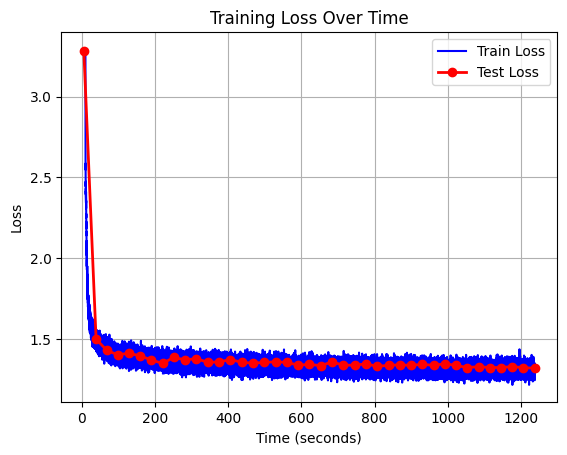

In [10]:
import matplotlib.pyplot as plt

# Plot full train loss
plt.plot(time_history, loss_history, label="Train Loss", color="blue")

# Plot test loss only at the recorded intervals
plt.plot(time_test_history, loss_test_history, 'o-', label="Test Loss", color="red", lw=2)

plt.xlabel("Time (seconds)")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend(loc="upper right")
plt.grid(True)
plt.show()

## Save Model and Config

In [11]:
import flax
from google.colab import drive
import pickle

# Mount Google Drive
drive.mount('/content/drive')

# Paths to save
params_path = "/content/drive/MyDrive/final_model_params.pkl"
config_path = "/content/drive/MyDrive/final_model_config.pkl"

### Save model parameters
# Convert JAX params to a plain Python dict for pickling
params_dict = flax.serialization.to_state_dict(params)

with open(params_path, "wb") as f:
    pickle.dump(params_dict, f)

print(f"Saved model parameters to {params_path}")

### Save model configuration
# Remove function objects (initializers) that cannot be pickled
config_copy = final_model_config.copy()
config_copy.pop("kernel_init", None)
config_copy.pop("proj_init", None)

with open(config_path, "wb") as f:
    pickle.dump(config_copy, f)

print(f"Saved model config to {config_path}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saved model parameters to /content/drive/MyDrive/final_model_params.pkl
Saved model config to /content/drive/MyDrive/final_model_config.pkl


To reload model

In [ ]:
import pickle
import flax
import jax

# Load config
with open("final_model_config.pkl", "rb") as f:
    config_loaded = pickle.load(f)

# Restore parameters
with open("final_model_params.pkl", "rb") as f:
    params_loaded = pickle.load(f)

# Recreate model
model_restored, _ = create_train_state(jax.random.PRNGKey(0), **config_loaded)

# Apply model
# logits = model_restored.apply({"params": params_loaded}, x_batch, deterministic=True)
